# Assignment 2: Convolutional Neural Networks

**Version Release Date**: 2023-01-29

**Due Date**: Friday, Feb. 24, at 11:59pm

Based on an assignment by Lisa Zhang

For CSC413/2516 in Winter 2023 with Professors Jimmy Ba and Bo Wang

**Submission:**
You must submit two files through [MarkUs](https://markus.teach.cs.toronto.edu/2022-01/): a PDF file containing your writeup, titled *a2-writeup.pdf*, and your code file *a2-code.ipynb*. Your writeup must be typeset.

The programming assignments are individual work. See the Course Syllabus for detailed policies. 

**Introduction:**  
This assignment will focus on the applications of convolutional neural networks in various image processing tasks. We will train a convolutional neural network for a task known as image colourization. Given a greyscale image, we will predict the colour at each pixel. This a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple,  equally valid colourings. 

# Colab FAQ and Using GPU

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

You need to use the Colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
We will use the [CIFAR-10 data set](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. To make the problem easier, we will only use the “Horse” category from this data set. Now let’s learn to colour some horses!

The data loading script is included below. It can take up to a couple of minutes to download everything the first time.

All files are stored at `/content/csc413/a2/data/` folder.

#### Helper code
You can ignore the restart warning.

In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/a2/
%cd /content/csc413/a2

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

/content/csc413/a2


#### Download files

This may take 1 or 2 mins for the first time.

In [ ]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(
    fname="colours", origin="http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz", untar=True
)
# Download CIFAR dataset
m = load_cifar10()

File path: data/colours.tar.gz
Extracting file.
File path: data/cifar-10-batches-py.tar.gz
Extracting file.


# Image Colourization as Classification

We will select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 

This was already done for you, and cluster centers are provided in http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz, which was downloaded by the helper functions above. For simplicity, we will measure distance in RGB space. This is not ideal but reduces the software dependencies for this assignment.

## Helper code

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from load_data import load_cifar10

HORSE_CATEGORY = 7

#### Data related code

In [ ]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i : i + batch_size, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours, 1, 3, 1, 1])
    dists = np.linalg.norm(xs - cs, axis=2)  # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat


def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]


def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

#### Torch helper

In [ ]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """
    batch = outputs.size(0)
    loss_out = outputs.transpose(1, 3).contiguous().view([batch * 32 * 32, num_colours])
    loss_lab = labels.transpose(1, 3).contiguous().view([batch * 32 * 32])
    return criterion(loss_out, loss_lab)


def run_validation_step(
    cnn,
    criterion,
    test_grey,
    test_rgb_cat,
    batch_size,
    colours,
    plotpath=None,
    visualize=True,
    downsize_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey, test_rgb_cat, batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(
            criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
        )
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath:  # only plot if a path is provided
        plot(
            xs,
            ys,
            predicted.cpu().numpy(),
            colours,
            plotpath,
            visualize=visualize,
            compare_bilinear=downsize_input,
        )

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

#### Visualization

In [ ]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = get_cat_rgb(gtlabel[:10, 0, :, :], colours)
    predcolor = get_cat_rgb(output[:10, 0, :, :], colours)

    img_stack = [np.hstack(np.tile(grey, [1, 1, 1, 3])), np.hstack(gtcolor), np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )
        gt_input = np.transpose(
            gtcolor,
            [
                0,
                3,
                1,
                2
            ],
        )
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear),
        ]
    img = np.vstack(img_stack)

    plt.grid(None)
    plt.imshow(img, vmin=0.0, vmax=1.0)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)


def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax) * 255).astype(np.uint8))


def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]

    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + "/act" + str(id)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    images, labels = get_torch_vars(
        np.expand_dims(test_grey[id], 0), np.expand_dims(test_rgb_cat[id], 0)
    )
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0, 0, :, :], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1).save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
        img = np.tile(np.transpose(test_grey[id], [1, 2, 0]), [1, 1, 3])
    else:
        img = np.transpose(test_grey[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d_gt.png" % id))

    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack(
            [
                np.hstack(
                    [
                        add_border(filter)
                        for filter in activation[i * imgwidth : (i + 1) * imgwidth, :, :]
                    ]
                )
                for i in range(activation.shape[0] // imgwidth)
            ]
        )
        scipy.misc.imsave(path, img)

    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i + 1, id)), tensor.data.cpu().numpy()[0]
        )
    print("visualization results are saved to %s" % outdir)

#### Training

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb_cat, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(
                criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
            )
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(
                xs,
                ys,
                predicted.cpu().numpy(),
                colours,
                save_dir + "/train_%d.png" % epoch,
                args.visualize,
                args.downsize_input,
            )

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(
            cnn,
            criterion,
            test_grey,
            test_rgb_cat,
            args.batch_size,
            colours,
            save_dir + "/test_%d.png" % epoch,
            args.visualize,
            args.downsize_input,
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

## 4: Pooling and Upsampling

### 4.1 [0.5pt] [Type 1]

Complete the `PoolUpsampleNet` CNN model following the architecture described in the assignment handout.

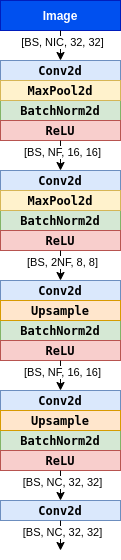

In the diagram above, we denote the number of filters as **NF**. Further layers double the number of filters, denoted as **2NF**. In the final layers, the number of filters will be equivalent to the number of colour classes, denoted as **NC**. Consequently, your constructed neural network should define the number of input/output layers with respect to the variables `num_filters` and `num_colours`, as opposed to a constant value.


The specific modules to use are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — The number of input filters should match the second dimension of the _input_ tensor (e.g. the first `nn.Conv2d` layer has **NIC** input filters). The number of output filters should match the second dimension of the _output_ tensor (e.g. the first `nn.Conv2d` layer has **NF** output filters). Set kernel size to parameter `kernel`. Set padding to the `padding` variable included in the starter code.
- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) — Use `kernel_size=2` for all layers.
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.BatchNorm2d) — The number of features is specified after the hyphen in the diagram as a multiple of **NF** or **NC**.
- [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample) — Use `scaling_factor=2` for all layers.
- [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)


We recommend grouping each block of operations (those adjacent without whitespace in the diagram) into [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) containers. Grouping up relevant operations will allow for easier implementation of the `forward` method.

**ChatGPT Prompt**

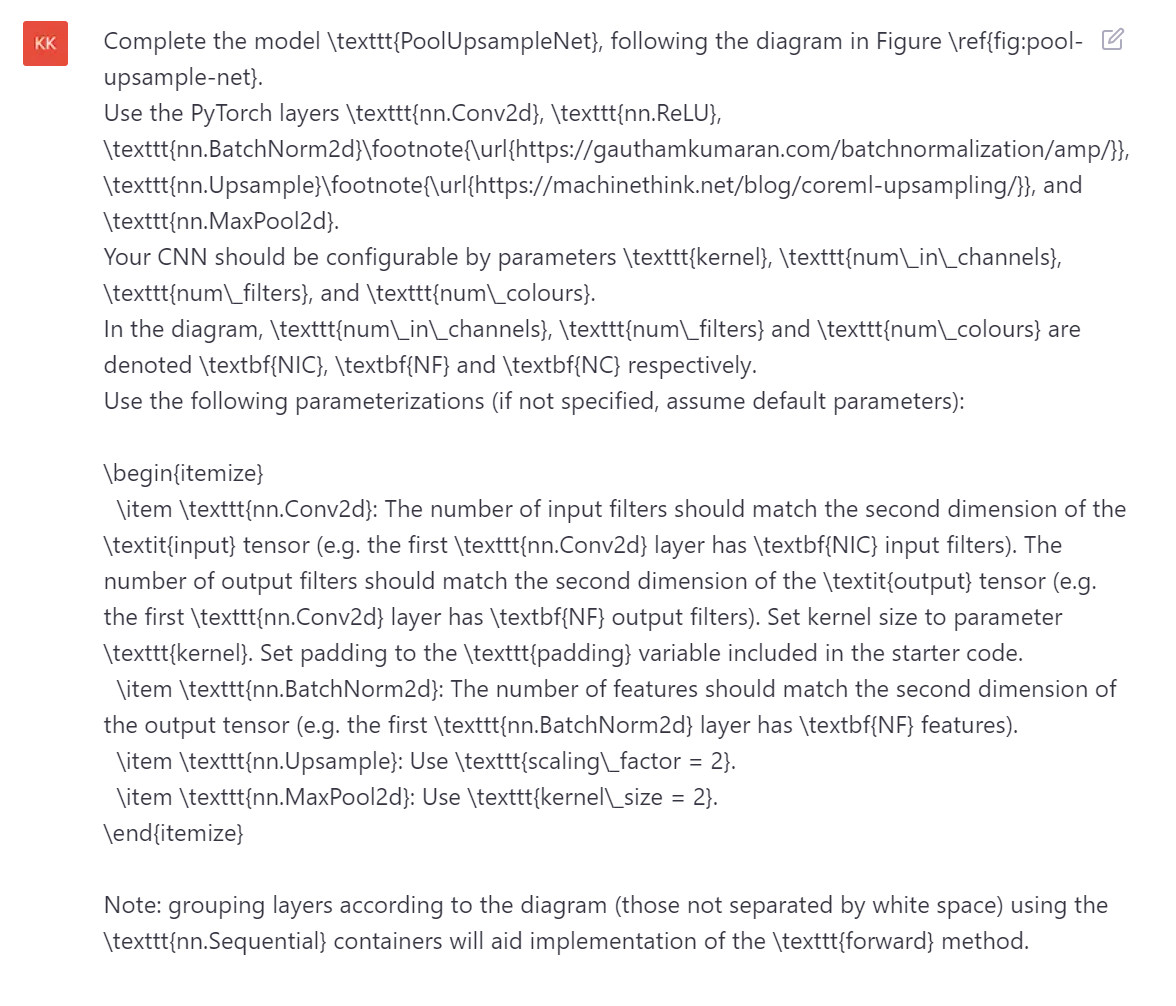

**ChatGPT Output**

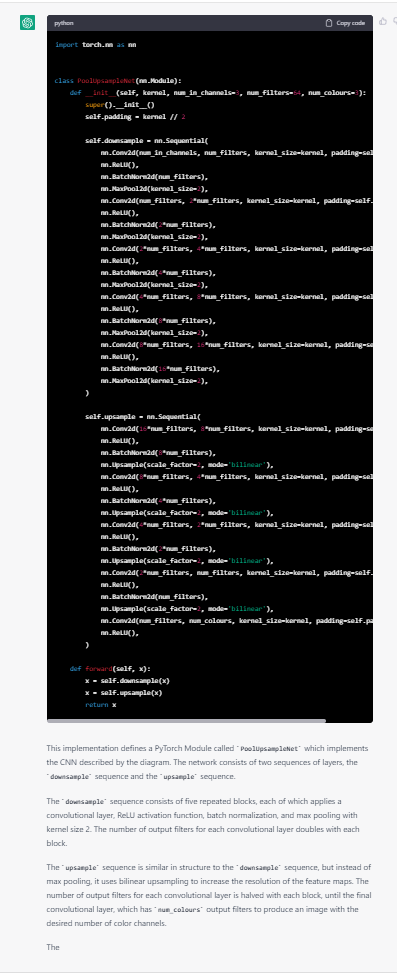

**ChatGPT Critique**

The output CNN has the wrong number of downsampling and upsampling units and the number of filters are wrong for some layers.

**My Solution**

In [ ]:
class PoolUpsampleNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ###############

        self.pool1 = nn.Sequential(
          nn.Conv2d(num_in_channels, num_filters, kernel, padding=padding),
          nn.MaxPool2d(2),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.pool2 = nn.Sequential(
          nn.Conv2d(num_filters, 2*num_filters, kernel, padding=padding),
          nn.MaxPool2d(2), # kernel_size
          nn.BatchNorm2d(2*num_filters),
          nn.ReLU()
        )
        self.up1 = nn.Sequential(
          nn.Conv2d(2*num_filters, num_filters, kernel, padding=padding),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.up2 = nn.Sequential(
          nn.Conv2d(num_filters, num_colours, kernel, padding=padding),
          nn.Upsample(scale_factor=2),
          nn.BatchNorm2d(num_colours),
          nn.ReLU()
        )
        self.conv = nn.Conv2d(num_colours, num_colours, kernel, padding=padding)

        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############

        x = self.pool1(x)
        x = self.pool2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.conv(x)
        return x
        
        ###################################################

### 4.2 [0.5pt] [Type 4]

Run main training loop of `PoolUpsampleNet`. This will train the CNN for a few epochs using the cross-entropy objective. It will generate some images showing the trained result at the end. Do these results look good to you? Why or why not?

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4373, Time (s): 7
Epoch [1/25], Val Loss: 2.1584, Val Acc: 26.9%, Time(s): 8.04
Epoch [2/25], Loss: 1.9966, Time (s): 8
Epoch [2/25], Val Loss: 1.9028, Val Acc: 33.8%, Time(s): 8.95
Epoch [3/25], Loss: 1.8757, Time (s): 9
Epoch [3/25], Val Loss: 1.8119, Val Acc: 35.9%, Time(s): 9.93
Epoch [4/25], Loss: 1.8135, Time (s): 10
Epoch [4/25], Val Loss: 1.7650, Val Acc: 37.0%, Time(s): 10.92
Epoch [5/25], Loss: 1.7740, Time (s): 11
Epoch [5/25], Val Loss: 1.7330, Val Acc: 37.8%, Time(s): 11.85
Epoch [6/25], Loss: 1.7458, Time (s): 12
Epoch [6/25], Val Loss: 1.7100, Val Acc: 38.3%, Time(s): 12.81
Epoch [7/25], Loss: 1.7241, Time (s): 13
Epoch [7/25], Val Loss: 1.6924, Val Acc: 38.7%, Time(s): 13.82
Epoch [8/25], Loss: 1.7066, Time (s): 14
Epoch [8/25], Val Loss: 1.6776, Val Acc: 39.1%, Time(s): 14.84
Epoch [9/25], Loss: 1.6923, Time (s): 15
Epoch [9/25], Val Loss: 1.6670

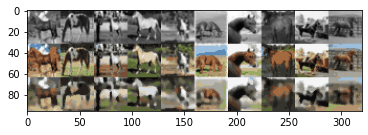

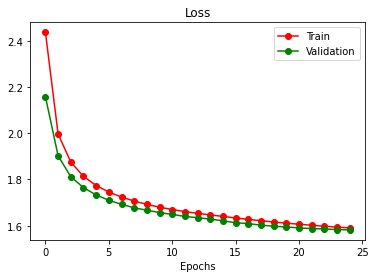

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "PoolUpsampleNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

The results look adequate although the images seem kind of blurry. However that may just be due to the low definition of the images. Some of the colour patches are not the right colour.

### 4.3 [1.0pt] [Type 3]

See assignment handout.

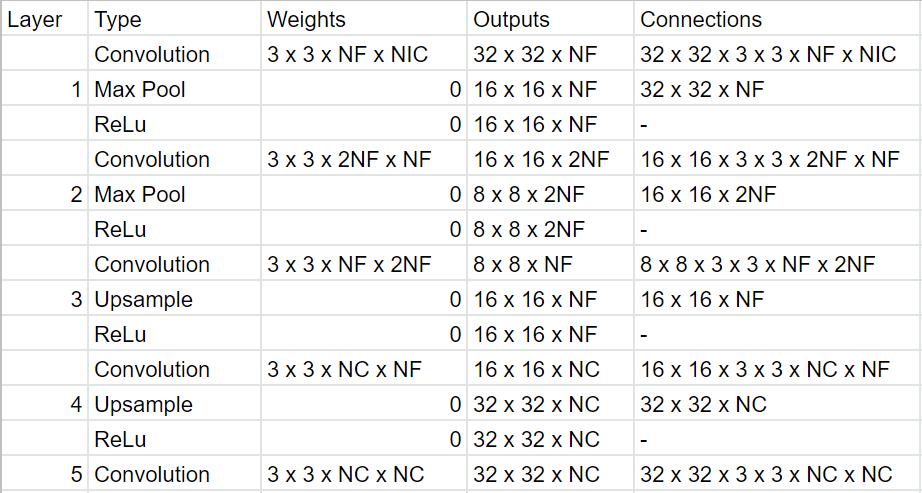

If the width and height of the input is doubled, the number of outputs and connections quadruples but the number of weights stay the same. The total number of weights, outputs and connections for the whole network can be calulated by summing up their columns.

## 5 Strided and Transposed Dilated Convolutions

### 5.1 [0.5pt] [Type 1]

Complete the `ConvTransposeNet` CNN model following the architecture described in the assignment handout.

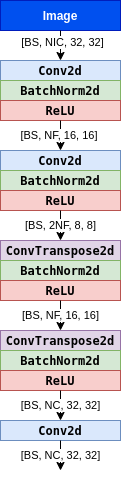

An excellent visualization of convolutions and transposed convolutions with strides can be found here: <https://github.com/vdumoulin/conv_arithmetic>.

The specific modules to use are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — The number of input and output filters, and the kernel size, should be set in the same way as Section 4. For the first two `nn.Conv2d` layers, set `stride` to 2 and set `padding` to 1.
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.BatchNorm2d) — The number of features should be specified in the same way as for Section 4.
- [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) — The number of input filters should match the second dimension of the _input_ tensor. The number of output filters should match the second dimension of the _output_ tensor. Set `kernel_size` to parameter `kernel`. Set `stride` to 2, set `dilation` to 1, and set both `padding` and `output_padding` to 1.
- [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)

**ChatGPT Prompt**

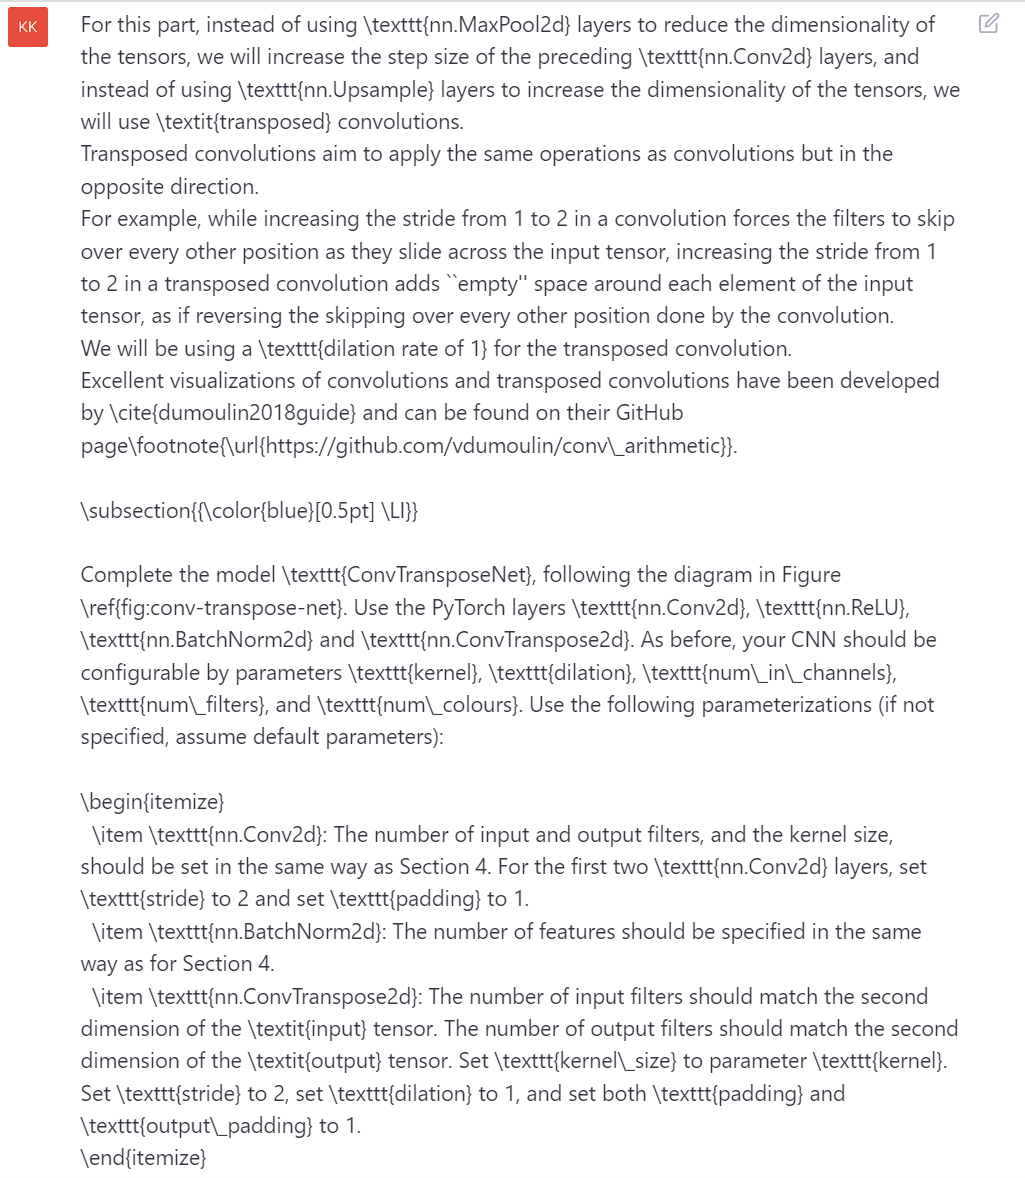

**ChatGPT Output**

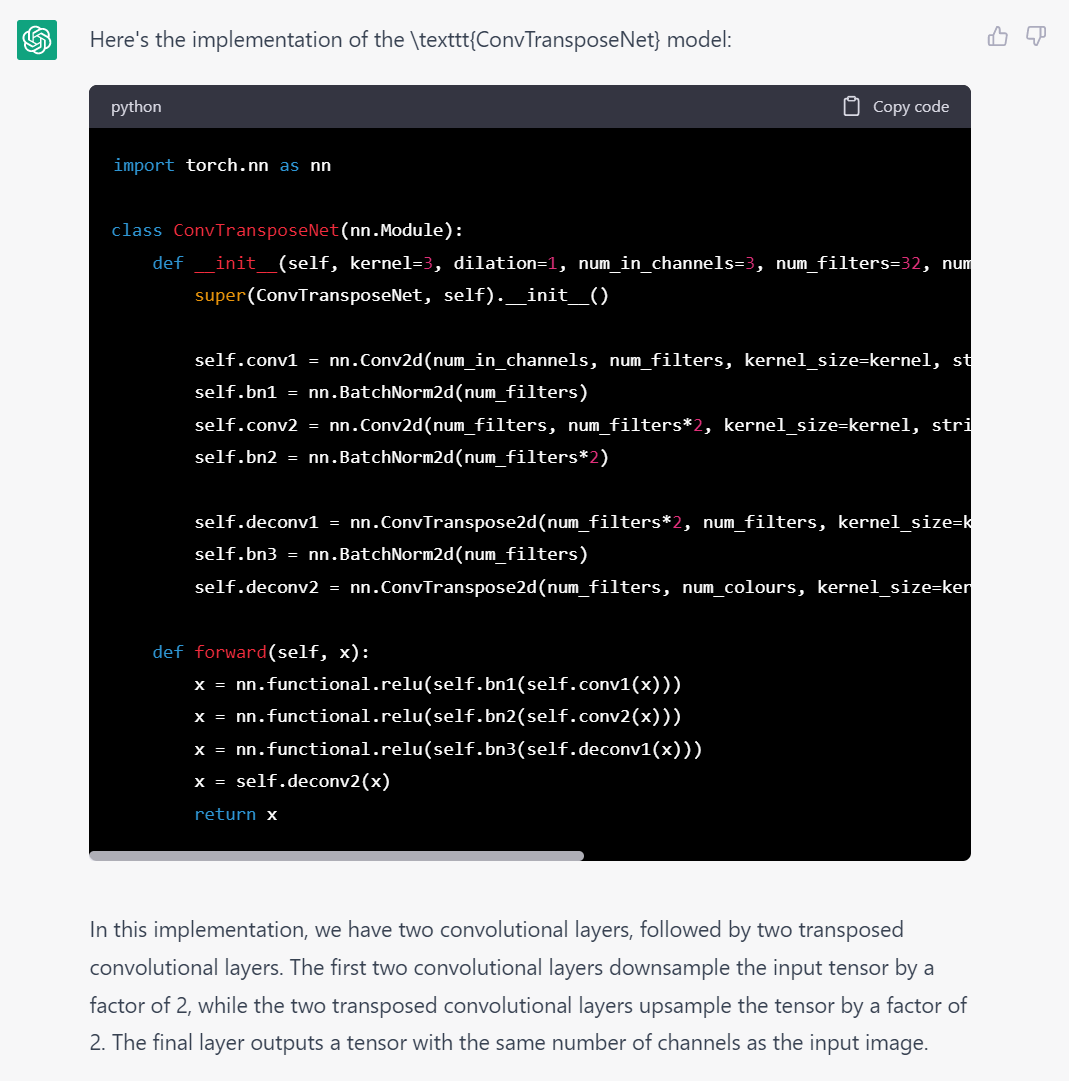

**ChatGPT Critique**

The ChatGPT output is correct except it is missing the last three layers, the fourth batch norm layer, the fourth ReLu layer, and the third convolutional layer.

**My Solution**

In [ ]:
class ConvTransposeNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 

        self.layer_1 = nn.Sequential(
          nn.Conv2d(num_in_channels, num_filters, kernel, padding=padding, stride=stride),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
          nn.Conv2d(num_filters, 2*num_filters, kernel, padding=padding, stride=stride),
          nn.BatchNorm2d(2*num_filters),
          nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
          nn.ConvTranspose2d(2*num_filters, num_filters, kernel, padding=padding, output_padding=output_padding, stride=stride),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
          nn.ConvTranspose2d(num_filters, num_colours, kernel, padding=padding, output_padding=output_padding, stride=stride),
          nn.BatchNorm2d(num_colours),
          nn.ReLU()
        )
        self.layer_5 = nn.Conv2d(num_colours, num_colours, kernel, padding=padding)

        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return x

        ###################################################

### 5.2 [0.5pt] [Type 4]

Train the model for at least 25 epochs using a batch size of 100 and a kernel size of 3. Plot the training curve, and include this plot in your write-up. How do the results compare to the previous model?

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.5115, Time (s): 0
Epoch [1/25], Val Loss: 2.1251, Val Acc: 30.3%, Time(s): 0.90
Epoch [2/25], Loss: 1.8659, Time (s): 1
Epoch [2/25], Val Loss: 1.7521, Val Acc: 37.3%, Time(s): 1.72
Epoch [3/25], Loss: 1.7042, Time (s): 2
Epoch [3/25], Val Loss: 1.6408, Val Acc: 40.2%, Time(s): 2.65
Epoch [4/25], Loss: 1.6222, Time (s): 3
Epoch [4/25], Val Loss: 1.5702, Val Acc: 42.1%, Time(s): 3.61
Epoch [5/25], Loss: 1.5623, Time (s): 4
Epoch [5/25], Val Loss: 1.5156, Val Acc: 43.6%, Time(s): 4.49
Epoch [6/25], Loss: 1.5141, Time (s): 5
Epoch [6/25], Val Loss: 1.4665, Val Acc: 45.3%, Time(s): 5.39
Epoch [7/25], Loss: 1.4738, Time (s): 6
Epoch [7/25], Val Loss: 1.4271, Val Acc: 46.5%, Time(s): 6.31
Epoch [8/25], Loss: 1.4400, Time (s): 7
Epoch [8/25], Val Loss: 1.3968, Val Acc: 47.3%, Time(s): 7.29
Epoch [9/25], Loss: 1.4115, Time (s): 8
Epoch [9/25], Val Loss: 1.3706, Val Acc: 

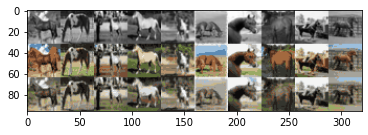

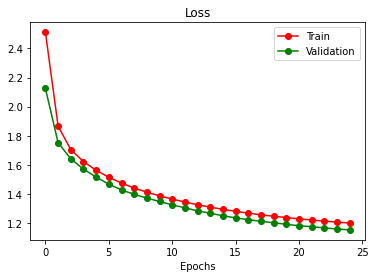

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "ConvTransposeNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

The results are better than the previous model. There is a lower validation loss (1.1509 vs 1.5753) and a higher validation accuracy (55% vs 41.5%).

### 5.3 – 5.5

See assignment handout.

**5.3**

The results are better than the previous model. There is a lower validation loss (1.1509 vs 1.5753) and a higher validation accuracy (55% vs 41.5%). The reason why the ConvTransposeNet model may have a lower validation loss than the PoolUpsampleNet model could be due to loss of feature information during pooling. 

PoolUpsampleNet uses pooling layers to downsample the feature maps which can cause information lass. The loss of information can make it difficult to reconstruct the original input from the feature maps, losing important details and decreasing model accuracy. ConvTransposeNet only uses covolution and transpose convolution layers to downsample and upsample the feature maps, which can help reduce information loss and preserve more detail.

**5.4**

Used formulas in documentation. First calculated $padding$ for Conv2d and then used the same $padding$ for ConvTranspose2d to calculate $output\_padding$. For the Conv2d calculation with kernel size 5, using the formula you would get $padding = 1.5$. However, $padding$ should be rounded up due to convolution behavior which takes the floor after dividing by the stride in the formula.

The parameters for $padding$ and $output\_padding$ given different kernel sizes are shown below:

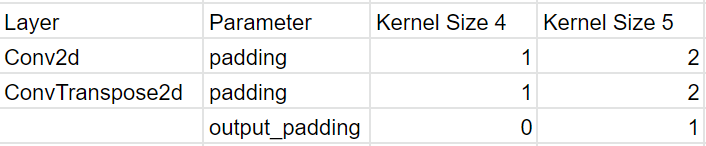

## 6 Skip Connections


A skip connection in a neural network is a connection which skips one or more layer and connects
to a later layer. We will introduce skip connections to our previous model.

### 6.1 [0.5pt] [Type 1]

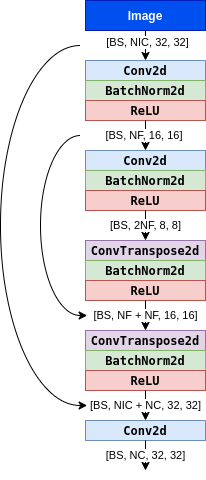

In this question, we will be adding a skip connection from the first layer to the last, second layer to the second last, etc. That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [Ronneberger et al.[2015]](https://arxiv.org/abs/1505.04597), and is called a ”UNet”. 

Just like the `ConvTransposeNet` class that you have completed in the previous part, complete the `__init__` and `forward` methods methods of the `UNet` class below.

Hint: You will need to use the function `torch.cat`.

**ChatGPT Prompt**

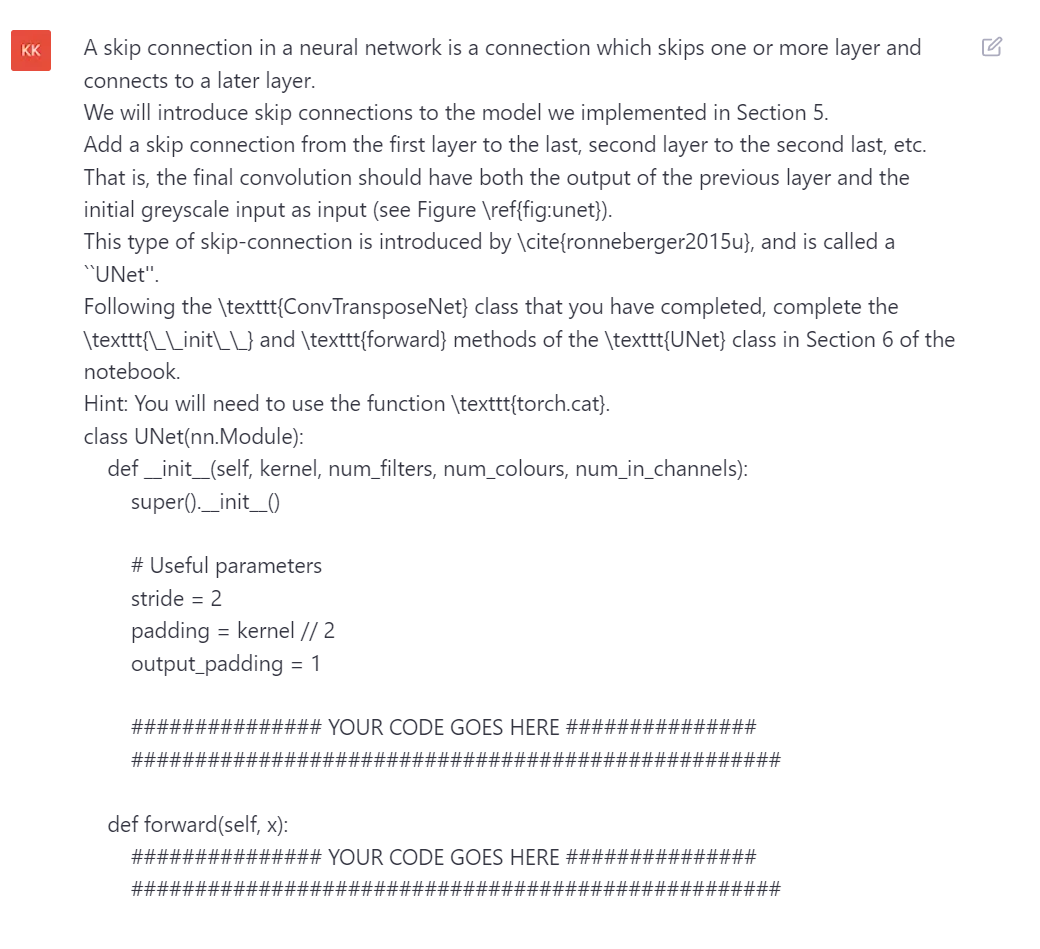

**ChatGPT Output**

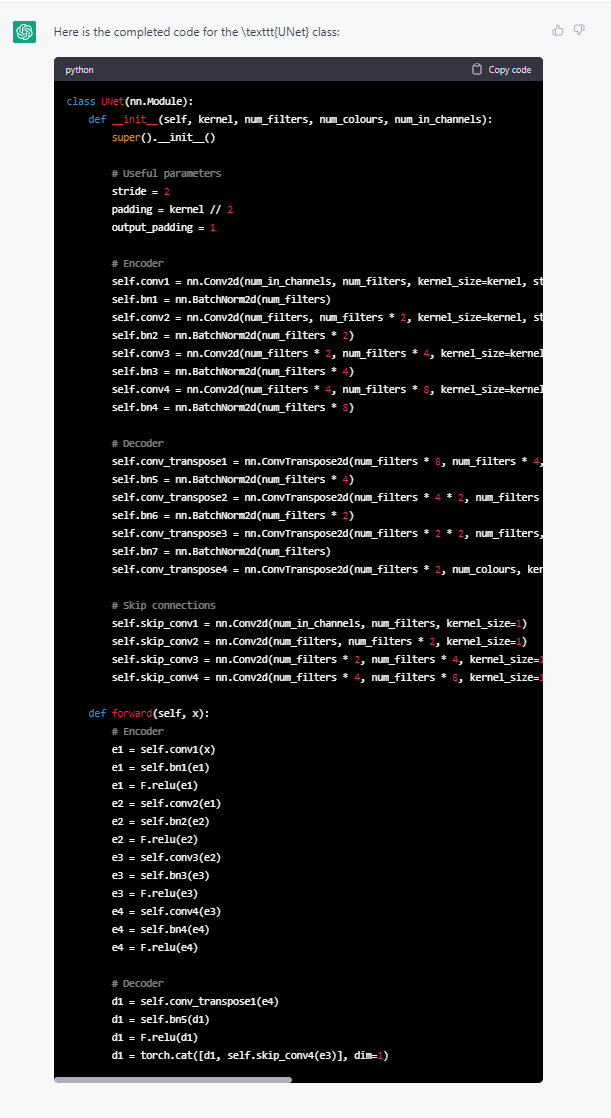

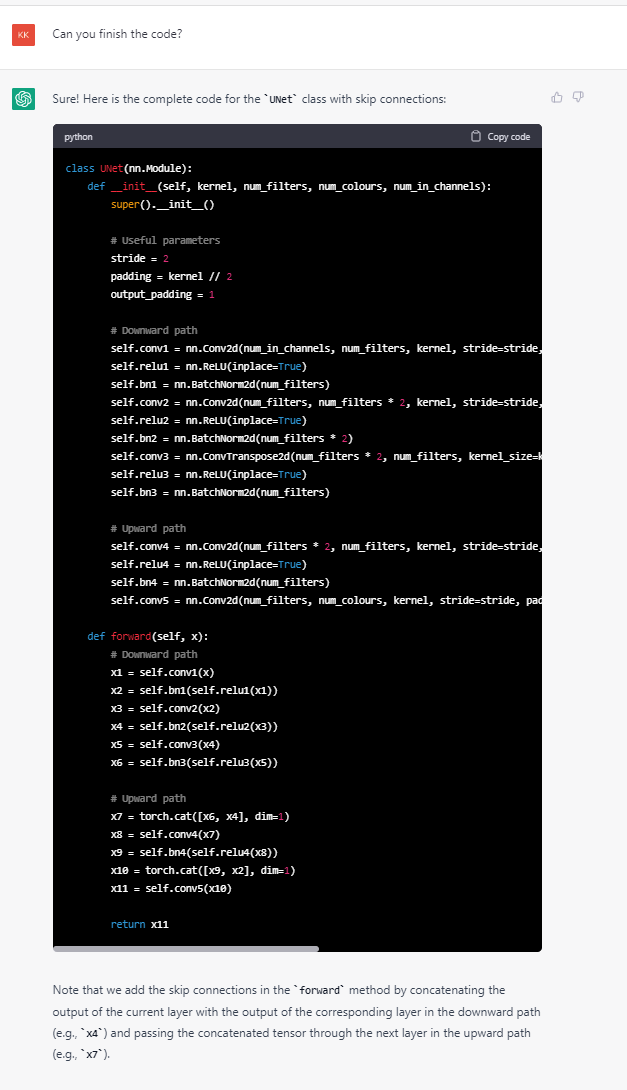

**ChatGPT Critique**

The final output is almost correct. The fourth convolution layer should be a ConvTranspose2d layer instead of a Conv2d layer. The first parameter in the fifth convolution layer function should be equal to $num\_colours+num\_in\_channels$. The skip connections should be between x6 and x2 as well as x9 and x. 

**My Solution**

In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############

        self.layer_1 = nn.Sequential(
          nn.Conv2d(num_in_channels, num_filters, kernel, padding=padding, stride=stride),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
          nn.Conv2d(num_filters, 2*num_filters, kernel, padding=padding, stride=stride),
          nn.BatchNorm2d(2*num_filters),
          nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
          nn.ConvTranspose2d(2*num_filters, num_filters, kernel, padding=padding, output_padding=output_padding, stride=stride),
          nn.BatchNorm2d(num_filters),
          nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
          nn.ConvTranspose2d(2*num_filters, num_colours, kernel, padding=padding, output_padding=output_padding, stride=stride),
          nn.BatchNorm2d(num_colours),
          nn.ReLU()
        )
        self.layer_5 = nn.Conv2d(num_colours+num_in_channels, num_colours, kernel, padding=padding)

        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############

        layer1 = self.layer_1(x)
        layer2 = self.layer_2(layer1)
        layer3 = self.layer_3(layer2)
        layer3 = torch.cat((layer3,layer1),1)
        layer4 = self.layer_4(layer3)
        layer4 = torch.cat((layer4,x),1)
        layer5 = self.layer_5(layer4)
        return layer5

        ###################################################

### 6.2 [0.5pt] [Type 4]

Train the model for at least 25 epochs using a batch size of 100 and a kernel size of 3. Plot the training curve, and include this plot in your write-up.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4428, Time (s): 0
Epoch [1/25], Val Loss: 2.0352, Val Acc: 31.2%, Time(s): 0.94
Epoch [2/25], Loss: 1.8154, Time (s): 1
Epoch [2/25], Val Loss: 1.7318, Val Acc: 37.3%, Time(s): 1.72
Epoch [3/25], Loss: 1.6367, Time (s): 2
Epoch [3/25], Val Loss: 1.5956, Val Acc: 41.2%, Time(s): 2.54
Epoch [4/25], Loss: 1.5434, Time (s): 3
Epoch [4/25], Val Loss: 1.5038, Val Acc: 44.2%, Time(s): 3.39
Epoch [5/25], Loss: 1.4755, Time (s): 4
Epoch [5/25], Val Loss: 1.4322, Val Acc: 46.6%, Time(s): 4.28
Epoch [6/25], Loss: 1.4218, Time (s): 4
Epoch [6/25], Val Loss: 1.3772, Val Acc: 48.6%, Time(s): 5.20
Epoch [7/25], Loss: 1.3777, Time (s): 5
Epoch [7/25], Val Loss: 1.3324, Val Acc: 50.1%, Time(s): 6.17
Epoch [8/25], Loss: 1.3407, Time (s): 6
Epoch [8/25], Val Loss: 1.2947, Val Acc: 51.3%, Time(s): 7.19
Epoch [9/25], Loss: 1.3093, Time (s): 7
Epoch [9/25], Val Loss: 1.2639, Val Acc: 

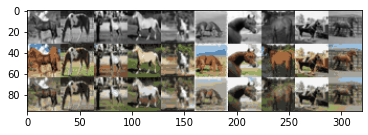

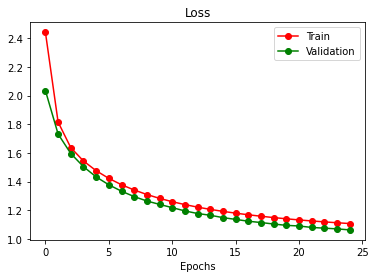

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

### 6.3 [1.0pt] [Type 3]

See assignment handout.

The results are better than the previous models. There is a lower validation loss (1.0619 vs 1.1509 and 1.5753) and a higher validation accuracy (58.2% vs 55% and 41.5%). The skip connections also improved the output qualitatively, increasing the accuracy of the image color scheme compared to the ground truth and increasing sharpness of the images. There are two reasons why skip connections may improve the performance of the CNN models:

1. Skip connections may allow the network to remember lower level features during downsampling that can be reused during upsampling, increasing information flow and information retention throughout the network.

2. Skip connections may decrease the vanishing gradient issue by allowing the gradient to flow easier through the network bypassing some intermediate layers, increasing the rate that the validation loss converges. The vanishing gradient refers to the gradient signal decreasing as it propagates through the layers of the network.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab\ Notebooks/
!sudo apt-get install texlive-xetex
!jupyter nbconvert a2-code.ipynb --to pdf

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
[NbConvertApp] Converting notebook a2-code.ipynb to pdf
[NbConvertApp] Support files will be in a2-code_files/
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Making directory ./a2-code_files
[NbConvertApp] Writing 133318 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibte